<a href="https://colab.research.google.com/github/maxkolganow/urfu-hackathon-dataton-winter-2022/blob/main/car_vs_moto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Подключение необходимых библиотек.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Установим google-парсер для поиска фото.
!pip install icrawler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from google.colab import files

'''
  Импортируем модуль os для 
  а) создания папок с метриками
  б) последовательного считывания всех фото из папок с метриками
'''
import os.path
from os import path
from os import walk


# Импортируем uuid для генерации уникальных идентификаторов
import uuid

# Импортируем zipfile для создания архивов с тренировочными и тестовыми данными
from zipfile import ZipFile

# Парсинг средствами GoogleImageCrawler
from icrawler.builtin import GoogleImageCrawler

# Отключить предупреждения
import warnings

# Для конвертации из jpg в png
import cv2

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path
import imghdr

In [ ]:
%matplotlib inline

In [ ]:
warnings.filterwarnings('ignore')

# 2. Создание метрик. 

## 2.1. Определение метрик.

In [ ]:
# Определим датасеты
dataset1 = 'car'
dataset2 = 'moto'

In [ ]:
# Определим метрики
'''
  maker - производитель
  class - типа кузова
  angle - ракурс
'''

# metrics_car = {
#     'maker': ['Hyunday','Toyota','BMW','Mercedes','Lamborghini','Tesla','Honda','Nissan','Volkswagen'],
#     'class': ['Saloon', 'Hatchback','Estate','Coupe','Convertible','Crossover','Sportcar','Roadster'],
#     'angle': ['Front','Back','Left','Right']
# }

# metrics_moto = {
#     'maker': ['Harley Davidson','Yamaha','Honda','Ducati','Kawasaki','BMW','Suzuki','Aprilia','Triumph'],
#     'class': ['Superbike', 'Classic','Motard','Dragster','Minibike','Sportbike','Enduro','Motocross'],
#     'angle': ['Front','Back','Left','Right']

metrics_car = {
    'maker': ['Hyunday','Toyota','BMW','Mercedes','Lamborghini','Tesla','Honda'],
    'class': ['Saloon', 'Hatchback','Estate','Coupe','Convertible','Crossover'],
    'angle': ['Front','Back','Left','Right']
}

metrics_moto = {
    'maker': ['Harley Davidson','Yamaha','Honda','Ducati','Kawasaki','BMW','Suzuki'],
    'class': ['Superbike', 'Classic','Motard','Dragster','Minibike','Sportbike',],
    'angle': ['Front','Back','Left','Right']
}

## 2.2. Создание директорий для метрик.

In [ ]:
path_to_data = '/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/'
# Создадим папку data
if not path.exists(path_to_data):
  os.mkdir(path_to_data)

# Создадим папки test и train:
if not path.exists(path_to_data + 'test/'):
  os.mkdir(path_to_data + 'test/')
if not path.exists(path_to_data + 'train/'):
  os.mkdir(path_to_data + 'train/')

# Создадим папки car и moto для dataset1 внутри test и train:
if not path.exists(path_to_data + 'test/' + dataset1):
  os.mkdir(path_to_data + 'test/' + dataset1)
if not path.exists(path_to_data + 'train/' + dataset1):
  os.mkdir(path_to_data + 'train/' + dataset1)

# Создадим папки car и moto для dataset2 внутри test и train:
if not path.exists(path_to_data + 'test/' + dataset2):
  os.mkdir(path_to_data + 'test/' + dataset2)
if not path.exists(path_to_data + 'train/' + dataset2):
  os.mkdir(path_to_data + 'train/' + dataset2)


In [ ]:
# Создаем папки для метрик car
for maker in metrics_car['maker']:
  for class_ in metrics_car['class']:
    for angle in metrics_car['angle']:
      new_folder = maker + '-' + class_ + '-' + angle

      # Папки для test-car
      if not path.exists(path_to_data + 'test/car/' + new_folder):
        os.mkdir(path_to_data + 'test/car/' + new_folder)
      
      # Папки для train-car
      if not path.exists(path_to_data + 'train/car/' + new_folder):
        os.mkdir(path_to_data + 'train/car/' + new_folder)
      

In [ ]:
# Создаем папки для метрик moto
for maker in metrics_moto['maker']:
  for class_ in metrics_moto['class']:
    for angle in metrics_moto['angle']:
      new_folder = maker + '-' + class_ + '-' + angle
      
      # Папки для test-moto
      if not path.exists(path_to_data + 'test/moto/' + new_folder):
        os.mkdir(path_to_data + 'test/moto/' + new_folder)
      
      # Папки для train-moto
      if not path.exists(path_to_data + 'train/moto/' + new_folder):
        os.mkdir(path_to_data + 'train/moto/' + new_folder)

# 3. Парсинг.

In [ ]:
# Если датасеты уже наполнены => не делаем парсинг. 
DATA_IS_FILLED = False


if not DATA_IS_FILLED:
  # Количество фото для каждого триплета = для каждого сочетания метрик = количество фото в КАЖДОЙ папке.
  quantity = 3

  # Поочередно заполняем 4 набора данных: test-car, test-moto, train-car, train-moto

  # test-car *********************************************************************************************

  '''
    При обходе директории с помощью walk, dirpath первым аргументом будет содержать то же что и path в walk(path).
    Поэтому первую итерацию нужно пропустить.
  '''
  skip_the_first_one = True 

  test_car_path = path_to_data + 'test/car/'
  for (dirpath, dirnames, filenames) in walk(test_car_path):
    if skip_the_first_one:
      skip_the_first_one = False
      continue
    
    '''
      Сформируем запрос для поиска.
      Для этого выделим из имени папки производитель, типа корпуса и ракурс > сформируем из них строку.
    '''
    name_folder = dirpath.split('/')[-1]

    # Выделим метрики из имени папок
    maker = name_folder.split('-')[0]
    class_ = name_folder.split('-')[1]
    angle = name_folder.split('-')[-1]

    request = maker + ' ' + class_ + ' ' + angle
    # print(maker, class_, angle)

    # Создадим объект GoogleImageCrawler для запроса.
    try:
      google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
                                        storage = {'root_dir' : dirpath})
      google_crawler.session.verify = False
      google_crawler.crawl(keyword=request, max_num=quantity, filters={'type':'photo'}, min_size=(500,500))
    except:
      pass


  # test-moto *********************************************************************************************

  '''
    При обходе директории с помощью walk, dirpath первым аргументом будет содержать то же что и path в walk(path).
    Поэтому первую итерацию нужно пропустить.
  '''
  skip_the_first_one = True 

  test_moto_path = path_to_data + 'test/moto/'
  for (dirpath, dirnames, filenames) in walk(test_moto_path):
    if skip_the_first_one:
      skip_the_first_one = False
      continue
    
    '''
      Сформируем запрос для поиска.
      Для этого выделим из имени папки производитель, типа корпуса и ракурс > сформируем из них строку.
    '''
    name_folder = dirpath.split('/')[-1]

    # Выделим метрики из имени папок
    maker = name_folder.split('-')[0]
    class_ = name_folder.split('-')[1]
    angle = name_folder.split('-')[-1]

    request = maker + ' ' + class_ + ' ' + angle
    # print(maker, class_, angle)

    # Создадим объект GoogleImageCrawler для запроса.
    try:
      google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
                                        storage = {'root_dir' : dirpath})
      google_crawler.session.verify = False
      google_crawler.crawl(keyword=request, max_num=quantity, filters={'type':'photo'}, min_size=(500,500))
    except:
      pass


  # train-car *********************************************************************************************

  '''
    При обходе директории с помощью walk, dirpath первым аргументом будет содержать то же что и path в walk(path).
    Поэтому первую итерацию нужно пропустить.
  '''
  skip_the_first_one = True 

  train_car_path = path_to_data + 'train/car/'
  for (dirpath, dirnames, filenames) in walk(train_car_path):
    if skip_the_first_one:
      skip_the_first_one = False
      continue
    
    '''
      Сформируем запрос для поиска.
      Для этого выделим из имени папки производитель, типа корпуса и ракурс > сформируем из них строку.
    '''
    name_folder = dirpath.split('/')[-1]

    # Выделим метрики из имени папок
    maker = name_folder.split('-')[0]
    class_ = name_folder.split('-')[1]
    angle = name_folder.split('-')[-1]

    request = class_ + ' ' + maker + ' ' + angle + ' side'
    # print(maker, class_, angle)

    # Создадим объект GoogleImageCrawler для запроса.
    try:
      google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
                                        storage = {'root_dir' : dirpath})
      google_crawler.session.verify = False
      google_crawler.crawl(keyword=request, max_num=quantity, filters={'type':'photo'}, min_size=(500,500))
    except:
      pass

  # train-moto *********************************************************************************************

  '''
    При обходе директории с помощью walk, dirpath первым аргументом будет содержать то же что и path в walk(path).
    Поэтому первую итерацию нужно пропустить.
  '''
  skip_the_first_one = True 

  train_moto_path = path_to_data + 'train/moto/'
  for (dirpath, dirnames, filenames) in walk(train_moto_path):
    if skip_the_first_one:
      skip_the_first_one = False
      continue
    
    '''
      Сформируем запрос для поиска.
      Для этого выделим из имени папки производитель, типа корпуса и ракурс > сформируем из них строку.
    '''
    name_folder = dirpath.split('/')[-1]

    # Выделим метрики из имени папок
    maker = name_folder.split('-')[0]
    class_ = name_folder.split('-')[1]
    angle = name_folder.split('-')[-1]

    request = class_ + ' ' + maker + ' ' + angle + ' side'
    # print(maker, class_, angle)

    # Создадим объект GoogleImageCrawler для запроса.
    try:
      google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
                                        storage = {'root_dir' : dirpath})
      google_crawler.session.verify = False
      google_crawler.crawl(keyword=request, max_num=quantity, filters={'type':'photo'}, min_size=(500,500))
    except:
      pass

ERROR:downloader:Exception caught when downloading file https://www.netcarshow.com/Hyundai-i40-2012-1600-47.jpg, error: HTTPSConnectionPool(host='www.netcarshow.com', port=443): Max retries exceeded with url: /Hyundai-i40-2012-1600-47.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9b13e1e160>, 'Connection to www.netcarshow.com timed out. (connect timeout=5)')), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.netcarshow.com/Hyundai-i40-2012-1600-3d.jpg, error: HTTPSConnectionPool(host='www.netcarshow.com', port=443): Max retries exceeded with url: /Hyundai-i40-2012-1600-3d.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9b13e1e8e0>, 'Connection to www.netcarshow.com timed out. (connect timeout=5)')), remaining retry times: 2
ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/2019_Hyundai_Accent_1.6L

# 4. Предварительная обработка.


In [ ]:
import cv2

In [ ]:
# Валидная конвертация.

# test-car ************************************************************
test_car_path = path_to_data + 'test/car/'
for (dirpath, dirnames, filenames) in walk(test_car_path):
  if filenames:
    for filename in filenames:

      return_val = cv2.haveImageReader(dirpath + '/' + filename)
      if return_val:
        # Load .png image
        image = cv2.imread(dirpath + '/' + filename)

        # Save .jpg image
        cv2.imwrite(dirpath + '/' + filename.split('.')[0]+'.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

# test-moto ************************************************************      
test_moto_path = path_to_data + 'test/moto/'
for (dirpath, dirnames, filenames) in walk(test_moto_path):
  if filenames:
    for filename in filenames:

      return_val = cv2.haveImageReader(dirpath + '/' + filename)
      if return_val:
        # Load .png image
        image = cv2.imread(dirpath + '/' + filename)

        # Save .jpg image
        cv2.imwrite(dirpath + '/' + filename.split('.')[0]+'.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

# train-car ************************************************************      
train_car_path = path_to_data + 'train/car/'
for (dirpath, dirnames, filenames) in walk(train_car_path):
  if filenames:
    for filename in filenames:

      return_val = cv2.haveImageReader(dirpath + '/' + filename)
      if return_val:
        # Load .png image
        image = cv2.imread(dirpath + '/' + filename)

        # Save .jpg image
        cv2.imwrite(dirpath + '/' + filename.split('.')[0]+'.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

# train-moto ************************************************************      
train_moto_path = path_to_data + 'train/moto/'
for (dirpath, dirnames, filenames) in walk(train_moto_path):
  if filenames:
    for filename in filenames:

      return_val = cv2.haveImageReader(dirpath + '/' + filename)
      if return_val:
        # Load .png image
        image = cv2.imread(dirpath + '/' + filename)

        # Save .jpg image
        cv2.imwrite(dirpath + '/' + filename.split('.')[0]+'.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

## 4.1. Переименование файлов с изображениями.

In [ ]:
'''
  Переименование файлов с фото в правильный формат: 
  "MakerX-ClassX-AngleZ", где Maker - производитель, Class - тип авто (например Sportcar).
'''

# test-car
test_car_path = path_to_data + 'test/car/'
for (dirpath, dirnames, filenames) in walk(test_car_path):
  if filenames:
    count_ = 0
    for filename in filenames:
      print(dirpath)

      # Найдем в пути к файлу названия метрик чтобы сформировать его новое имя.
      metric_name = dirpath.split('/')[-1]
      maker = metric_name.split('-')[0]
      class_ = metric_name.split('-')[1]
      angle = metric_name.split('-')[-1]

      new_file_name = dirpath + '/' + maker + '-' + class_ + '-' + angle + '_' + str(count_) + '.jpg'

      os.rename(dirpath + '/' + filename, new_file_name)
      count_ += 1

# **************************************************************************

# test-moto
test_moto_path = path_to_data + 'test/moto/'
for (dirpath, dirnames, filenames) in walk(test_moto_path):
  if filenames:
    count_ = 0
    for filename in filenames:
      print(dirpath)

      # Найдем в пути к файлу названия метрик чтобы сформировать его новое имя.
      metric_name = dirpath.split('/')[-1]
      maker = metric_name.split('-')[0]
      class_ = metric_name.split('-')[1]
      angle = metric_name.split('-')[-1]

      new_file_name = dirpath + '/' + maker + '-' + class_ + '-' + angle + '_' + str(count_) + '.jpg'

      os.rename(dirpath + '/' + filename, new_file_name)
      count_ += 1

# **************************************************************************

# train-car
train_car_path = path_to_data + 'train/car/'
for (dirpath, dirnames, filenames) in walk(train_car_path):
  if filenames:
    count_ = 0
    for filename in filenames:
      print(dirpath)

      # Найдем в пути к файлу названия метрик чтобы сформировать его новое имя.
      metric_name = dirpath.split('/')[-1]
      maker = metric_name.split('-')[0]
      class_ = metric_name.split('-')[1]
      angle = metric_name.split('-')[-1]

      new_file_name = dirpath + '/' + maker + '-' + class_ + '-' + angle + '_' + str(count_) + '.jpg'

      os.rename(dirpath + '/' + filename, new_file_name)
      count_ += 1

# **************************************************************************

# train-moto
train_moto_path = path_to_data + 'train/moto/'
for (dirpath, dirnames, filenames) in walk(train_moto_path):
  if filenames:
    count_ = 0
    for filename in filenames:
      print(dirpath)

      # Найдем в пути к файлу названия метрик чтобы сформировать его новое имя.
      metric_name = dirpath.split('/')[-1]
      maker = metric_name.split('-')[0]
      class_ = metric_name.split('-')[1]
      angle = metric_name.split('-')[-1]

      new_file_name = dirpath + '/' + maker + '-' + class_ + '-' + angle + '_' + str(count_) + '.jpg'

      os.rename(dirpath + '/' + filename, new_file_name)
      count_ += 1

/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Front
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Front
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Front
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Back
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Back
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Back
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Left
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/Hackathons/Winter 2022/data/test/car/Hyunday-Saloon-Left
/content/drive/MyDrive/Colab Notebooks/Magistratura 1: UrFU/H

# 5. Обход директорий с данными.

## 5.1. `Test`

### 5.1.1. `test-car`

Обход `test-car` => считываем каждое фото, присваиваем ему `ID` с помощью `uuid` => получим итоговый df с исчерпывающей информацией по каждому фото. 

In [ ]:
test_car_dict = {}

# Списки для извелченных метрик из названий файлов при обходе директории
IDs = []
makers = []
classes = []
angles = []
inner_IDs = []

test_car_path = path_to_data + 'test/car/'
for (dirpath, dirnames, filenames) in walk(test_car_path):
  if filenames:
    for filename in filenames:

      # Извлекаем метрики из названия каждого файла
      clean_file_name = filename.split('.')[0]
      maker = clean_file_name.split('-')[0]
      class_ = clean_file_name.split('-')[1]
      angle = clean_file_name.split('-')[2].split('_')[0]
      inner_ID = clean_file_name.split('-')[2].split('_')[-1]

      # Добавляем в списки метрики, извлеченные из названия
      IDs.append( str(uuid.uuid4()) )
      makers.append(maker)
      classes.append(class_)
      angles.append(angle)
      inner_IDs.append(inner_ID)

test_car_df = pd.DataFrame({
    'ID': IDs,
    'maker': makers,
    'class': classes,
    'angle': angles,
    'Inner ID': inner_IDs
})

test_car_df

,ID,maker,class,angle,Inner ID
0,17f709e4-204d-4628-a55d-245fbaaaa9c0,Hyunday,Saloon,Front,0
1,e0629314-ab0b-4542-8b41-6ff1e68aea33,Hyunday,Saloon,Front,1
2,5349ecec-8a00-425f-875f-035d80fe4ab8,Hyunday,Saloon,Front,2
3,e7efad83-02ce-4a0c-b445-e353cd78045c,Hyunday,Saloon,Back,0
4,ba46829b-b82a-4d34-8105-60f3b4fd054e,Hyunday,Saloon,Back,1
...,...,...,...,...,...
506,819a021b-f990-4d74-8fb6-3b3e137468ce,Honda,Crossover,Left,2
507,ba45ead6-1c19-494f-aecc-e02b21798cab,Honda,Crossover,Right,0
508,148b41ea-37a8-4001-bc47-59e7ac41b9ad,Honda,Crossover,Right,1
509,ddaf0f51-90b7-4e03-b265-7819ddbd6fd4,Honda,Crossover,Right,2


Заносим считанные фото из `test-car` в `test`-архив:

In [ ]:
test_car_zip = ZipFile(path_to_data + 'test.zip', 'w')
def union_test_car(item):
  test_car_read_path = path_to_data + 'test/car/' +\
          item['maker'] + '-'+ item['class'] + '-' + item['angle'] +'/' + \
          item['maker'] + '-' + \
          item['class'] + '-' + \
          item['angle'] + '_' + \
          item['Inner ID'] + \
          '.jpg'

  name_photo_in_zip = '/test/car/' + \
                      item['ID'] + '---' + \
                      item['maker'] + '-' + \
                      item['class'] + '-' + \
                      item['angle'] + '.jpg'

  test_car_zip.write(test_car_read_path, name_photo_in_zip)

test_car_df.apply(union_test_car, axis=1)
test_car_zip.close()

### 5.1.2. `test-moto`

Обход `test-moto` => считываем каждое фото, присваиваем ему `ID` с помощью `uuid` => получим итоговый `df` с исчерпывающей информацией по каждому фото. 

In [ ]:
test_moto_dict = {}

# Списки для извелченных метрик из названий файлов при обходе директории
IDs = []
makers = []
classes = []
angles = []
inner_IDs = []

test_moto_path = path_to_data + 'test/moto/'
for (dirpath, dirnames, filenames) in walk(test_moto_path):
  if filenames:
    for filename in filenames:
      print(filename)
      clean_file_name = filename.split('.')[0]
      maker = clean_file_name.split('-')[0]
      class_ = clean_file_name.split('-')[1]
      angle = clean_file_name.split('-')[2].split('_')[0]
      inner_ID = clean_file_name.split('-')[2].split('_')[-1]


      IDs.append( str(uuid.uuid4()) )
      makers.append(maker)
      classes.append(class_)
      angles.append(angle)
      inner_IDs.append(inner_ID)

test_moto_df = pd.DataFrame({
    'ID': IDs,
    'maker': makers,
    'class': classes,
    'angle': angles,
    'Inner ID': inner_IDs
})
test_moto_df

Harley Davidson-Superbike-Front_0.jpg
Harley Davidson-Superbike-Front_1.jpg
Harley Davidson-Superbike-Front_2.jpg
Harley Davidson-Superbike-Back_0.jpg
Harley Davidson-Superbike-Back_1.jpg
Harley Davidson-Superbike-Back_2.jpg
Harley Davidson-Superbike-Left_0.jpg
Harley Davidson-Superbike-Left_1.jpg
Harley Davidson-Superbike-Left_2.jpg
Harley Davidson-Superbike-Right_0.jpg
Harley Davidson-Superbike-Right_1.jpg
Harley Davidson-Superbike-Right_2.jpg
Harley Davidson-Classic-Front_0.jpg
Harley Davidson-Classic-Front_1.jpg
Harley Davidson-Classic-Front_2.jpg
Harley Davidson-Classic-Back_0.jpg
Harley Davidson-Classic-Back_1.jpg
Harley Davidson-Classic-Back_2.jpg
Harley Davidson-Classic-Left_0.jpg
Harley Davidson-Classic-Left_1.jpg
Harley Davidson-Classic-Left_2.jpg
Harley Davidson-Classic-Right_0.jpg
Harley Davidson-Classic-Right_1.jpg
Harley Davidson-Classic-Right_2.jpg
Harley Davidson-Motard-Front_0.jpg
Harley Davidson-Motard-Front_1.jpg
Harley Davidson-Motard-Front_2.jpg
Harley Davidson-Mot

,ID,maker,class,angle,Inner ID
0,7d820282-11f5-4040-bcf0-dd109158080f,Harley Davidson,Superbike,Front,0
1,f85deab5-df6a-4469-bfc1-a4572516a86f,Harley Davidson,Superbike,Front,1
2,c1a8dff7-c625-482d-857b-e2e69af18c83,Harley Davidson,Superbike,Front,2
3,bb901744-142d-494a-9fb2-c8852f9c64b5,Harley Davidson,Superbike,Back,0
4,8c7813da-7fcb-4c65-8daf-2a408c1c4f2f,Harley Davidson,Superbike,Back,1
...,...,...,...,...,...
517,3ba037d1-d91d-4b1a-807e-32fea689a659,Suzuki,Sportbike,Left,3
518,65179a80-1d0f-424c-801f-8e6c17bf9c51,Suzuki,Sportbike,Right,0
519,6b54ac21-afc0-420a-ac01-63aa752305fa,Suzuki,Sportbike,Right,1
520,a29382a5-9d6a-4e73-a76f-f156a8366400,Suzuki,Sportbike,Right,2


In [ ]:
# with ZipFile('/content/drive/MyDrive/Colab Notebooks/Магистратура 1: УрФУ/Хакатоны/Зима 2022/data/test_moto.zip', 'w') as test_moto_zip:
#   test_moto_zip.write('/content/drive/MyDrive/Colab Notebooks/Магистратура 1: УрФУ/Хакатоны/Зима 2022/data/test/moto/Maker1-Class1-Angle1/maker1-class1-angle1_0000.jpg',
#                       '/test/hello.jpg')

Заносим считанные фото из `test-moto` в `test`-архив:

In [ ]:
test_moto_zip = ZipFile(path_to_data + 'test.zip', 'a')
def union_test_moto(item):
  test_moto_read_path = path_to_data + 'test/moto/' +\
          item['maker'] + '-'+ item['class'] + '-' + item['angle'] +'/' + \
          item['maker'] + '-' + \
          item['class'] + '-' + \
          item['angle'] + '_' + \
          item['Inner ID'] + \
          '.jpg'

  name_photo_in_zip = '/test/moto/' + \
                      item['ID'] + '---' + \
                      item['maker'] + '-' + \
                      item['class'] + '-' + \
                      item['angle'] + '.jpg'

  test_moto_zip.write(test_moto_read_path, name_photo_in_zip)

test_moto_df.apply(union_test_moto, axis=1)
test_moto_zip.close()


##№ 5.2. `Train`

### 5.2.1. `train-car`

Обход `train-car` => считываем каждое фото, присваиваем ему `ID` с помощью `uuid` => получим итоговый `df` с исчерпывающей информацией по каждому фото.

In [ ]:
train_car_dict = {}

# Списки для извелченных метрик из названий файлов при обходе директории.
IDs = []
makers = []
classes = []
angles = []
inner_IDs = []

train_car_path = path_to_data + 'train/car/'
for (dirpath, dirnames, filenames) in walk(train_car_path):
  if filenames:
    for filename in filenames:

      # Извлекаем метрики из названия каждого файла
      clean_file_name = filename.split('.')[0]
      maker = clean_file_name.split('-')[0]
      class_ = clean_file_name.split('-')[1]
      angle = clean_file_name.split('-')[2].split('_')[0]
      inner_ID = clean_file_name.split('-')[2].split('_')[-1]

      # Добавляем в списки метрики, извлеченные из названия
      IDs.append( str(uuid.uuid4()) )
      makers.append(maker)
      classes.append(class_)
      angles.append(angle)
      inner_IDs.append(inner_ID)

train_car_df = pd.DataFrame({
    'ID': IDs,
    'maker': makers,
    'class': classes,
    'angle': angles,
    'Inner ID': inner_IDs
})

train_car_df

,ID,maker,class,angle,Inner ID
0,374c58b2-062a-4baa-b4aa-4e7aff423a4a,Hyunday,Saloon,Front,0
1,db3de961-3174-42a2-9aef-8ce02420f891,Hyunday,Saloon,Front,1
2,667551b4-6947-48fc-86da-fbfde46cb46c,Hyunday,Saloon,Front,2
3,9066095b-89bf-4381-8d8e-cb37eef8cf14,Hyunday,Saloon,Back,0
4,dd140cdf-210a-448b-a704-5039fe2d45c2,Hyunday,Saloon,Back,1
...,...,...,...,...,...
503,39969711-1636-44b5-892d-f1f9a92ddb1c,Honda,Crossover,Left,2
504,0f415bf3-b38e-4677-84dc-215299667244,Honda,Crossover,Right,0
505,852729c3-3536-4ed2-9fcb-8c2504c95cc4,Honda,Crossover,Right,1
506,8762a5a5-1ba9-441d-94a0-cd9d1c015580,Honda,Crossover,Right,2


Заносим считанные фото из `train-car` в `train`-архив:

In [ ]:
train_car_zip = ZipFile(path_to_data + 'train.zip', 'w')
def union_train_car(item):
  train_car_read_path = path_to_data + 'train/car/' +\
          item['maker'] + '-'+ item['class'] + '-' + item['angle'] +'/' + \
          item['maker'] + '-' + \
          item['class'] + '-' + \
          item['angle'] + '_' + \
          item['Inner ID'] + \
          '.jpg'

  name_photo_in_zip = '/train/car/' + \
                      item['ID'] + '---' + \
                      item['maker'] + '-' + \
                      item['class'] + '-' + \
                      item['angle'] + '.jpg'

  train_car_zip.write(train_car_read_path, name_photo_in_zip)

train_car_df.apply(union_train_car, axis=1)
train_car_zip.close()

## 5.2.2. `train-moto`

Обход `train-moto` => считываем каждое фото, присваиваем ему `ID` с помощью `uuid` => получим итоговый `df` с исчерпывающей информацией по каждому фото.

In [ ]:
train_moto_dict = {}

# Списки для извелченных метрик из названий файлов при обходе директории.
IDs = []
makers = []
classes = []
angles = []
inner_IDs = []

train_moto_path = path_to_data + 'train/moto/'
for (dirpath, dirnames, filenames) in walk(train_moto_path):
  if filenames:
    for filename in filenames:

      # Извлекаем метрики из названия каждого файла
      clean_file_name = filename.split('.')[0]
      maker = clean_file_name.split('-')[0]
      class_ = clean_file_name.split('-')[1]
      angle = clean_file_name.split('-')[2].split('_')[0]
      inner_ID = clean_file_name.split('-')[2].split('_')[-1]

      # Добавляем в списки метрики, извлеченные из названия
      IDs.append( str(uuid.uuid4()) )
      makers.append(maker)
      classes.append(class_)
      angles.append(angle)
      inner_IDs.append(inner_ID)

train_moto_df = pd.DataFrame({
    'ID': IDs,
    'maker': makers,
    'class': classes,
    'angle': angles,
    'Inner ID': inner_IDs
})

train_moto_df

,ID,maker,class,angle,Inner ID
0,6634bfe3-fdf0-40eb-9061-bafe762dbede,Harley Davidson,Superbike,Front,0
1,01e2397d-58c3-432e-b5b5-13428131f7b1,Harley Davidson,Superbike,Front,1
2,4f941e87-0d91-4019-bf50-d71be68fea44,Harley Davidson,Superbike,Back,0
3,1c541f46-a64a-404f-9618-2dbb07d9d4f4,Harley Davidson,Superbike,Back,1
4,91930efc-2d40-41aa-93b4-267830168a7d,Harley Davidson,Superbike,Back,2
...,...,...,...,...,...
507,ae155959-1e2c-4ab7-a08a-ef93ac663ee8,Suzuki,Sportbike,Left,0
508,9ed7bcdf-1c62-4bcc-8729-2a9a65efe51e,Suzuki,Sportbike,Left,1
509,f4e028e9-e45e-4b16-a383-54f86b6ceccd,Suzuki,Sportbike,Right,0
510,6463ff5a-ab90-4c13-b7b9-f7df1955a1a9,Suzuki,Sportbike,Right,1


Заносим считанные фото из `train-moto` в `train`-архив:

In [ ]:
train_moto_zip = ZipFile(path_to_data + 'train.zip', 'a')
def union_train_moto(item):
  train_moto_read_path = path_to_data + 'train/moto/' +\
          item['maker'] + '-'+ item['class'] + '-' + item['angle'] +'/' + \
          item['maker'] + '-' + \
          item['class'] + '-' + \
          item['angle'] + '_' + \
          item['Inner ID'] + \
          '.jpg'

  name_photo_in_zip = '/train/moto/' + \
                      item['ID'] + '---' + \
                      item['maker'] + '-' + \
                      item['class'] + '-' + \
                      item['angle'] + '.jpg'

  train_moto_zip.write(train_moto_read_path, name_photo_in_zip)

train_moto_df.apply(union_train_moto, axis=1)
train_moto_zip.close()

# 6. Визуализации.

Итого: мы имеем 4 `df`

*   `test_car_df`
*   `test_moto_df`
*   `train_car_df`
*   `train_car_df`

-> каждый из которых соответствует следующему набору данных
*   `test-car` | ТЕСТОВЫЕ ДАННЫЕ ДЛЯ МАШИН
*   `test-moto` | ТЕСТОВЫЕ ДАННЫЕ ДЛЯ МОТО
*   `train-car` | ТРЕНИРОВОЧНЫЕ ДАННЫЕ ДЛЯ МАШИН
*   `train-moto` | ТРЕНИРОВОЧНЫЕ ДАННЫЕ ДЛЯ МОТО

У каждого `df` определены слудующие столбцы:
`ID` - уникальный `df` в рамках ВСЕГО датасета, который формируется средствами `UUID`.
Оставшиеся стобцы соответствуеют выбранным метрикам:

*   `maker`
*   `class`
*   `angle`

=> 4 дата-фрейма по 3 метрики в каждом => 12 графиков для каждой метрики => мы сможем на графиках отслеживать равномерность заполнения данных. Если, допустим, в датасете будет всего 3 фото для производителя `BMW` и 120 для `Ferrari`, то это будет отображено на гистограмме.






In [ ]:
# Тестовые данные для машин.
test_car_df

,ID,maker,class,angle,Inner ID
0,17f709e4-204d-4628-a55d-245fbaaaa9c0,Hyunday,Saloon,Front,0
1,e0629314-ab0b-4542-8b41-6ff1e68aea33,Hyunday,Saloon,Front,1
2,5349ecec-8a00-425f-875f-035d80fe4ab8,Hyunday,Saloon,Front,2
3,e7efad83-02ce-4a0c-b445-e353cd78045c,Hyunday,Saloon,Back,0
4,ba46829b-b82a-4d34-8105-60f3b4fd054e,Hyunday,Saloon,Back,1
...,...,...,...,...,...
506,819a021b-f990-4d74-8fb6-3b3e137468ce,Honda,Crossover,Left,2
507,ba45ead6-1c19-494f-aecc-e02b21798cab,Honda,Crossover,Right,0
508,148b41ea-37a8-4001-bc47-59e7ac41b9ad,Honda,Crossover,Right,1
509,ddaf0f51-90b7-4e03-b265-7819ddbd6fd4,Honda,Crossover,Right,2


In [ ]:
# Тестовые данные для мото.
test_moto_df

,ID,maker,class,angle,Inner ID
0,7d820282-11f5-4040-bcf0-dd109158080f,Harley Davidson,Superbike,Front,0
1,f85deab5-df6a-4469-bfc1-a4572516a86f,Harley Davidson,Superbike,Front,1
2,c1a8dff7-c625-482d-857b-e2e69af18c83,Harley Davidson,Superbike,Front,2
3,bb901744-142d-494a-9fb2-c8852f9c64b5,Harley Davidson,Superbike,Back,0
4,8c7813da-7fcb-4c65-8daf-2a408c1c4f2f,Harley Davidson,Superbike,Back,1
...,...,...,...,...,...
517,3ba037d1-d91d-4b1a-807e-32fea689a659,Suzuki,Sportbike,Left,3
518,65179a80-1d0f-424c-801f-8e6c17bf9c51,Suzuki,Sportbike,Right,0
519,6b54ac21-afc0-420a-ac01-63aa752305fa,Suzuki,Sportbike,Right,1
520,a29382a5-9d6a-4e73-a76f-f156a8366400,Suzuki,Sportbike,Right,2


In [ ]:
# Тренировочные данные для авто.
train_car_df

,ID,maker,class,angle,Inner ID
0,374c58b2-062a-4baa-b4aa-4e7aff423a4a,Hyunday,Saloon,Front,0
1,db3de961-3174-42a2-9aef-8ce02420f891,Hyunday,Saloon,Front,1
2,667551b4-6947-48fc-86da-fbfde46cb46c,Hyunday,Saloon,Front,2
3,9066095b-89bf-4381-8d8e-cb37eef8cf14,Hyunday,Saloon,Back,0
4,dd140cdf-210a-448b-a704-5039fe2d45c2,Hyunday,Saloon,Back,1
...,...,...,...,...,...
503,39969711-1636-44b5-892d-f1f9a92ddb1c,Honda,Crossover,Left,2
504,0f415bf3-b38e-4677-84dc-215299667244,Honda,Crossover,Right,0
505,852729c3-3536-4ed2-9fcb-8c2504c95cc4,Honda,Crossover,Right,1
506,8762a5a5-1ba9-441d-94a0-cd9d1c015580,Honda,Crossover,Right,2


In [ ]:
# Тренировочные данные для мото.
train_car_df

,ID,maker,class,angle,Inner ID
0,374c58b2-062a-4baa-b4aa-4e7aff423a4a,Hyunday,Saloon,Front,0
1,db3de961-3174-42a2-9aef-8ce02420f891,Hyunday,Saloon,Front,1
2,667551b4-6947-48fc-86da-fbfde46cb46c,Hyunday,Saloon,Front,2
3,9066095b-89bf-4381-8d8e-cb37eef8cf14,Hyunday,Saloon,Back,0
4,dd140cdf-210a-448b-a704-5039fe2d45c2,Hyunday,Saloon,Back,1
...,...,...,...,...,...
503,39969711-1636-44b5-892d-f1f9a92ddb1c,Honda,Crossover,Left,2
504,0f415bf3-b38e-4677-84dc-215299667244,Honda,Crossover,Right,0
505,852729c3-3536-4ed2-9fcb-8c2504c95cc4,Honda,Crossover,Right,1
506,8762a5a5-1ba9-441d-94a0-cd9d1c015580,Honda,Crossover,Right,2


## 6.1. Покрытие датасета с помощью `Bar` средствами `Matplotlib`.

### 6.1.1. Отслеживание `Maker` = типов кузова.

#### test-car

In [ ]:
# Сгруппируем тестовые машины по производителю и посчитаем количество записей в каждой группе.
test_car_df_by_maker_count = test_car_df.groupby('maker').count()
test_car_df_by_maker_count.sort_values(by='ID', ascending=False, inplace=True)
test_car_df_by_maker_count

,ID,class,angle,Inner ID
maker,,,,
Tesla,76,76,76,76
Toyota,74,74,74,74
Honda,73,73,73,73
Hyunday,73,73,73,73
BMW,72,72,72,72
Lamborghini,72,72,72,72
Mercedes,71,71,71,71


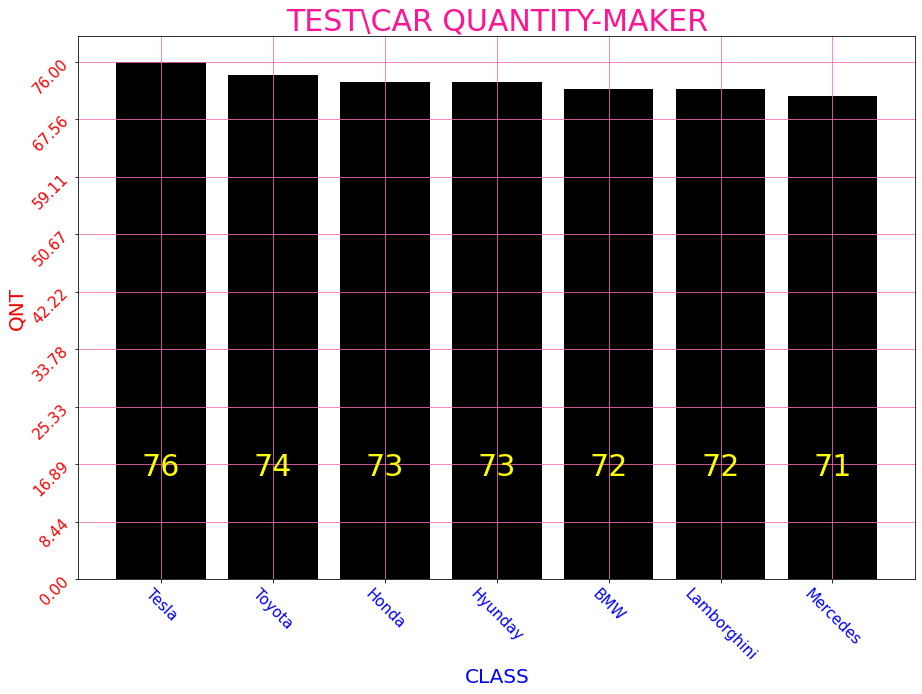

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_car_df_by_maker_count.index,
       height=test_car_df_by_maker_count['ID'],
       color='black')
plt.title('TEST\CAR QUANTITY-MAKER',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_car_df_by_maker_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_car_df_by_maker_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_car_df_by_maker_count['ID']):
    plt.text(index,
            test_car_df_by_maker_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### test-moto

In [ ]:
# Сгруппируем тестовые мото по производителю и посчитаем количество записей в каждой группе.
test_moto_df_maker_count = test_moto_df.groupby('maker').count()
test_moto_df_maker_count.sort_values(by='ID', ascending=False, inplace=True)
test_moto_df_maker_count

,ID,class,angle,Inner ID
maker,,,,
Suzuki,85,85,85,85
Kawasaki,76,76,76,76
BMW,74,74,74,74
Ducati,72,72,72,72
Harley Davidson,72,72,72,72
Honda,72,72,72,72
Yamaha,71,71,71,71


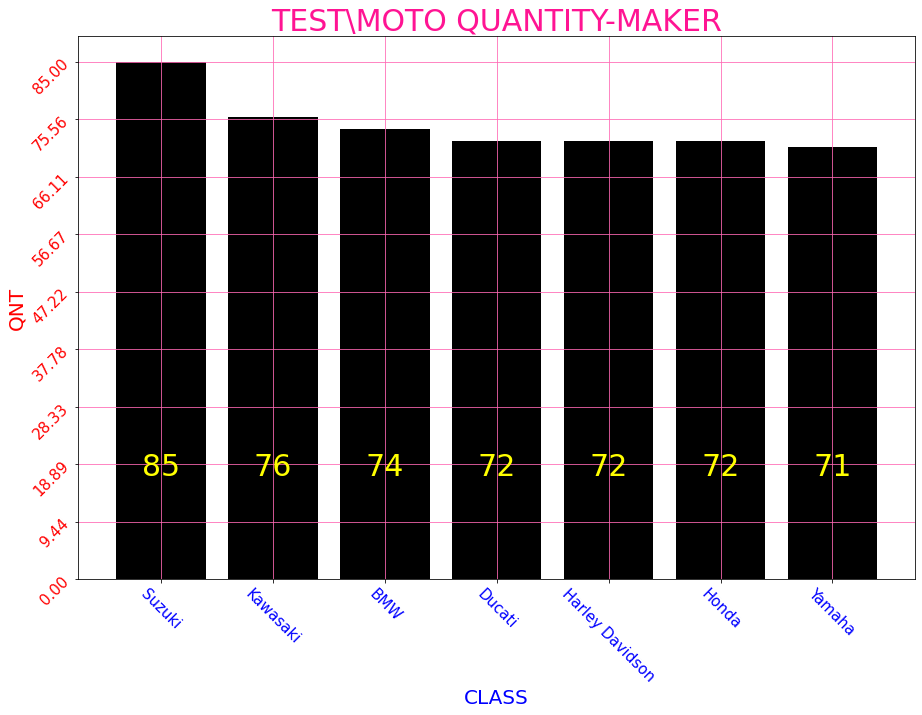

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_moto_df_maker_count.index,
       height=test_moto_df_maker_count['ID'],
       color='black')
plt.title('TEST\MOTO QUANTITY-MAKER',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_moto_df_maker_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_moto_df_maker_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_moto_df_maker_count['ID']):
    plt.text(index,
            test_moto_df_maker_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-car

In [ ]:
# Сгруппируем тренировочные машины по производителю и посчитаем количество записей в каждой группе.
train_car_df_maker_count = train_car_df.groupby('maker').count()
train_car_df_maker_count.sort_values(by='ID', ascending=False, inplace=True)
train_car_df_maker_count

,ID,class,angle,Inner ID
maker,,,,
Mercedes,75,75,75,75
Lamborghini,74,74,74,74
Hyunday,73,73,73,73
Tesla,73,73,73,73
Honda,72,72,72,72
BMW,71,71,71,71
Toyota,70,70,70,70


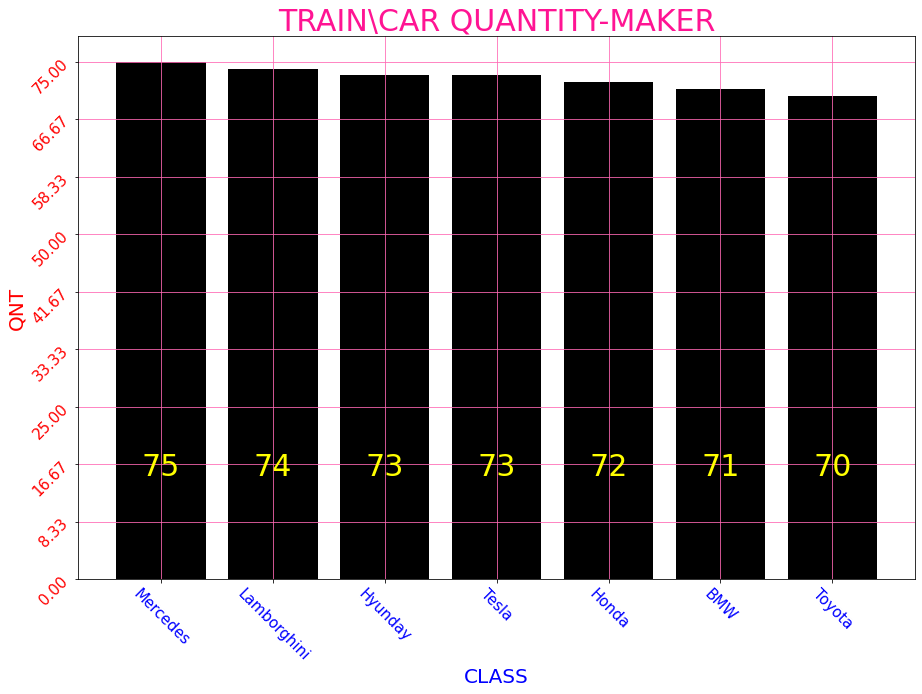

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_car_df_maker_count.index,
       height=train_car_df_maker_count['ID'],
       color='black')
plt.title('TRAIN\CAR QUANTITY-MAKER',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_car_df_maker_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_car_df_maker_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_car_df_maker_count['ID']):
    plt.text(index,
            train_car_df_maker_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-moto

In [ ]:
# Сгруппируем тренировочные мото по производителю и посчитаем количество записей в каждой группе.
train_moto_df_maker_count = train_moto_df.groupby('maker').count()
train_moto_df_maker_count.sort_values(by='ID', ascending=False, inplace=True)
train_moto_df_maker_count

,ID,class,angle,Inner ID
maker,,,,
Kawasaki,77,77,77,77
Ducati,75,75,75,75
Suzuki,75,75,75,75
Honda,73,73,73,73
BMW,72,72,72,72
Harley Davidson,70,70,70,70
Yamaha,70,70,70,70


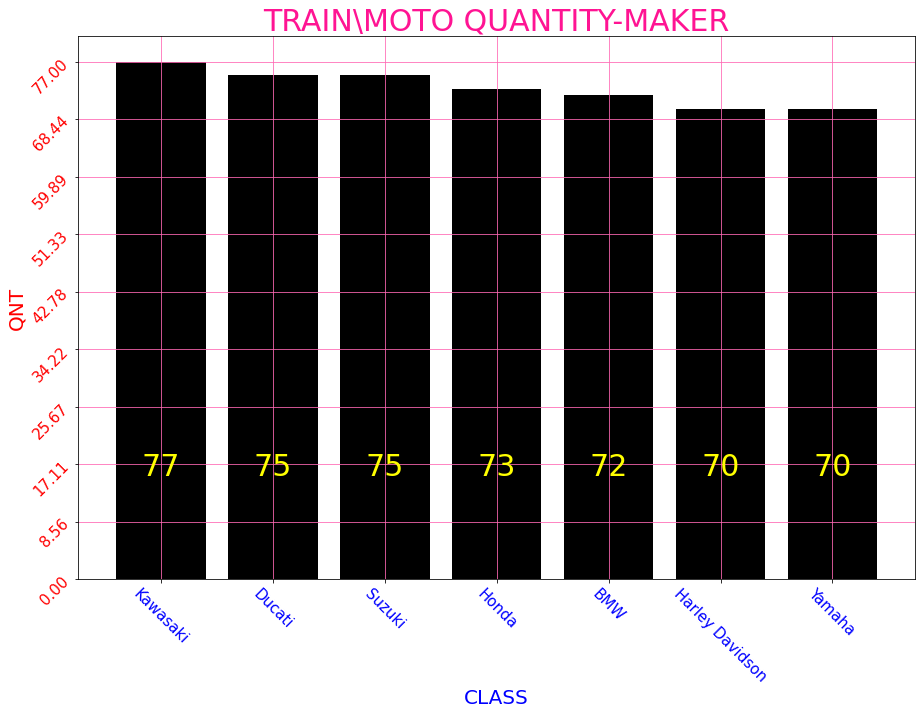

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_moto_df_maker_count.index,
       height=train_moto_df_maker_count['ID'],
       color='black')
plt.title('TRAIN\MOTO QUANTITY-MAKER',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_moto_df_maker_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_moto_df_maker_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_moto_df_maker_count['ID']):
    plt.text(index,
            train_moto_df_maker_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

### 6.2.1. Отслеживание `Class` = типов кузова.

#### test-car

In [ ]:
# Сгруппируем тестовые машины по типу кузова и посчитаем количество записей в каждой группе.
test_car_df_by_class_count = test_car_df.groupby('class').count()
test_car_df_by_class_count.sort_values(by='ID', ascending=False, inplace=True)
test_car_df_by_class_count

,ID,maker,angle,Inner ID
class,,,,
Estate,89,89,89,89
Saloon,86,86,86,86
Coupe,85,85,85,85
Crossover,85,85,85,85
Convertible,83,83,83,83
Hatchback,83,83,83,83


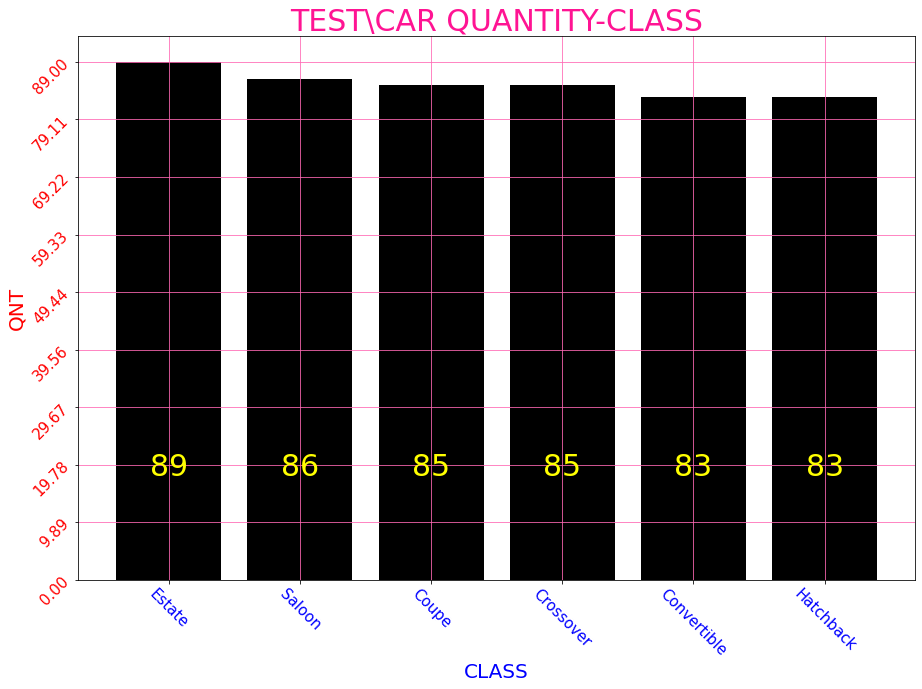

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_car_df_by_class_count.index,
       height=test_car_df_by_class_count['ID'],
       color='black')
plt.title('TEST\CAR QUANTITY-CLASS',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_car_df_by_class_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_car_df_by_class_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_car_df_by_class_count['ID']):
    plt.text(index,
            test_car_df_by_class_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### test-moto

In [ ]:
# Сгруппируем тестовые мото по типу кузова и посчитаем количество записей в каждой группе.
test_moto_df_class_count = test_moto_df.groupby('class').count()
test_moto_df_class_count.sort_values(by='ID', ascending=False, inplace=True)
test_moto_df_class_count

,ID,maker,angle,Inner ID
class,,,,
Motard,91,91,91,91
Sportbike,89,89,89,89
Superbike,89,89,89,89
Classic,85,85,85,85
Dragster,84,84,84,84
Minibike,84,84,84,84


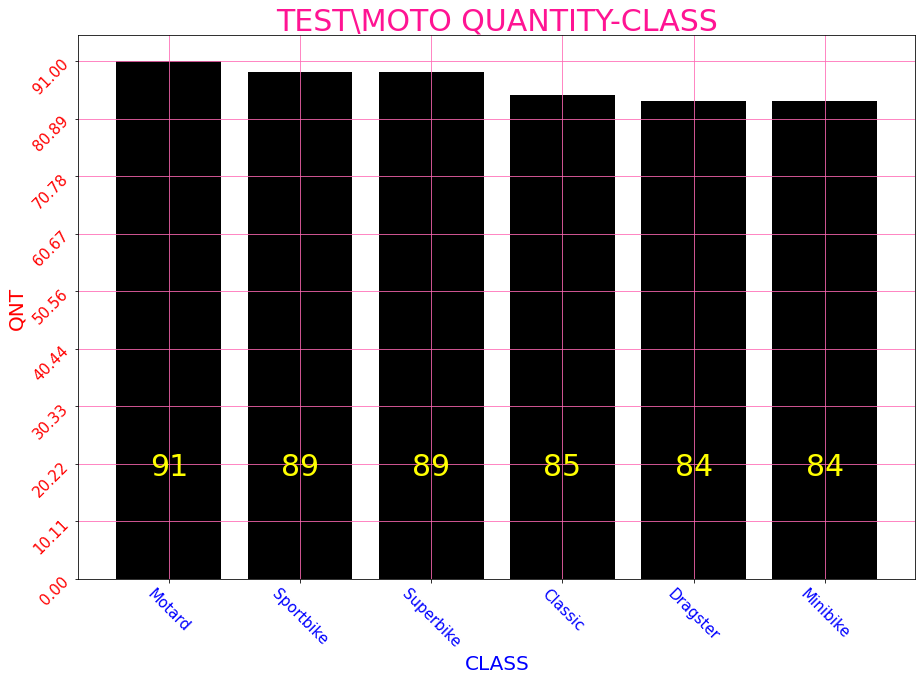

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_moto_df_class_count.index,
       height=test_moto_df_class_count['ID'],
       color='black')
plt.title('TEST\MOTO QUANTITY-CLASS',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_moto_df_class_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_moto_df_class_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_moto_df_class_count['ID']):
    plt.text(index,
            test_moto_df_class_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-car

In [ ]:
# Сгруппируем тренировочные машины по типу кузова и посчитаем количество записей в каждой группе.
train_car_df_class_count = train_car_df.groupby('class').count()
train_car_df_class_count.sort_values(by='ID', ascending=False, inplace=True)
train_car_df_class_count

,ID,maker,angle,Inner ID
class,,,,
Convertible,88,88,88,88
Hatchback,86,86,86,86
Estate,85,85,85,85
Crossover,84,84,84,84
Saloon,84,84,84,84
Coupe,81,81,81,81


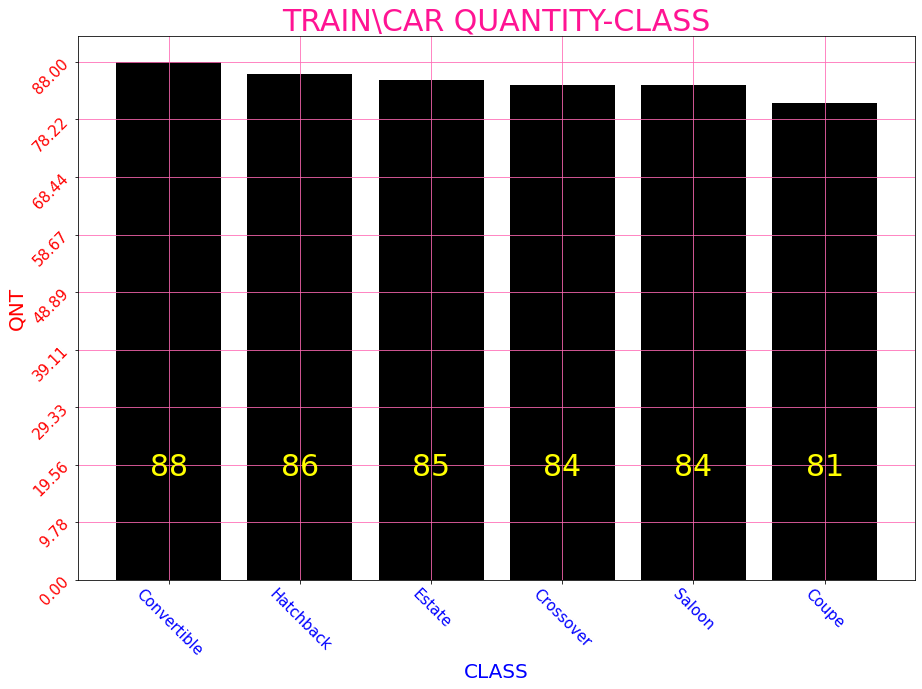

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_car_df_class_count.index,
       height=train_car_df_class_count['ID'],
       color='black')
plt.title('TRAIN\CAR QUANTITY-CLASS',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_car_df_class_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_car_df_class_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_car_df_class_count['ID']):
    plt.text(index,
            train_car_df_class_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-moto

In [ ]:
# Сгруппируем тренировочные мото по типу кузова и посчитаем количество записей в каждой группе.
train_moto_df_class_count = train_moto_df.groupby('class').count()
train_moto_df_class_count.sort_values(by='ID', ascending=False, inplace=True)
train_moto_df_class_count

,ID,maker,angle,Inner ID
class,,,,
Motard,88,88,88,88
Minibike,86,86,86,86
Superbike,86,86,86,86
Sportbike,85,85,85,85
Classic,84,84,84,84
Dragster,83,83,83,83


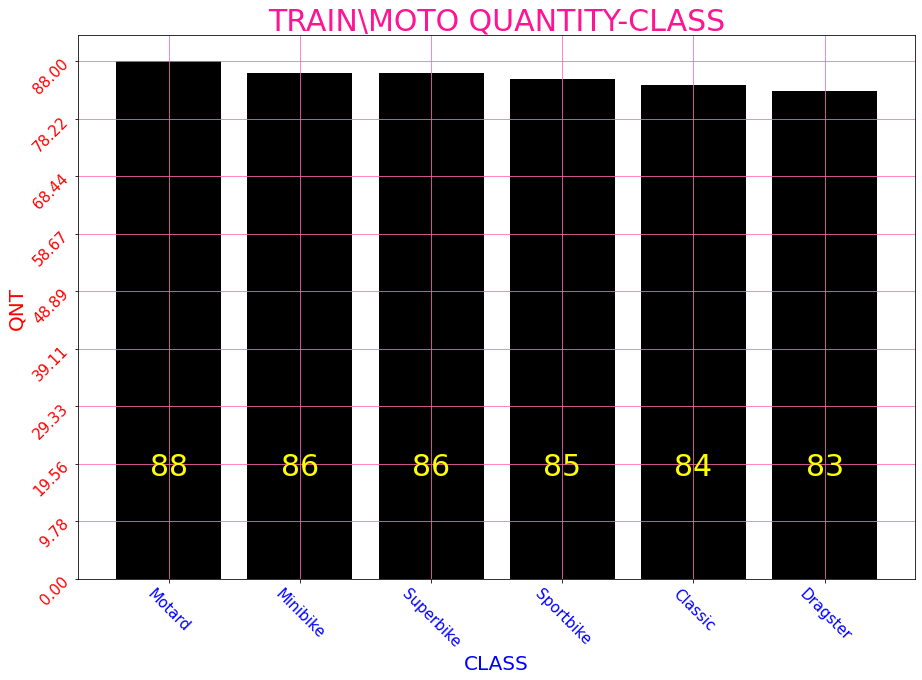

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_moto_df_class_count.index,
       height=train_moto_df_class_count['ID'],
       color='black')
plt.title('TRAIN\MOTO QUANTITY-CLASS',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_moto_df_class_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_moto_df_class_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_moto_df_class_count['ID']):
    plt.text(index,
            train_moto_df_class_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

### 6.3.1. Отслеживание `Angle` = ракурсов.

#### test-car

In [ ]:
# Сгруппируем тестовые машины ракурсу и посчитаем количество записей в каждой группе.
test_car_df_by_angle_count = test_car_df.groupby('angle').count()
test_car_df_by_angle_count.sort_values(by='ID', ascending=False, inplace=True)
test_car_df_by_angle_count

,ID,maker,class,Inner ID
angle,,,,
Front,131,131,131,131
Left,128,128,128,128
Right,127,127,127,127
Back,125,125,125,125


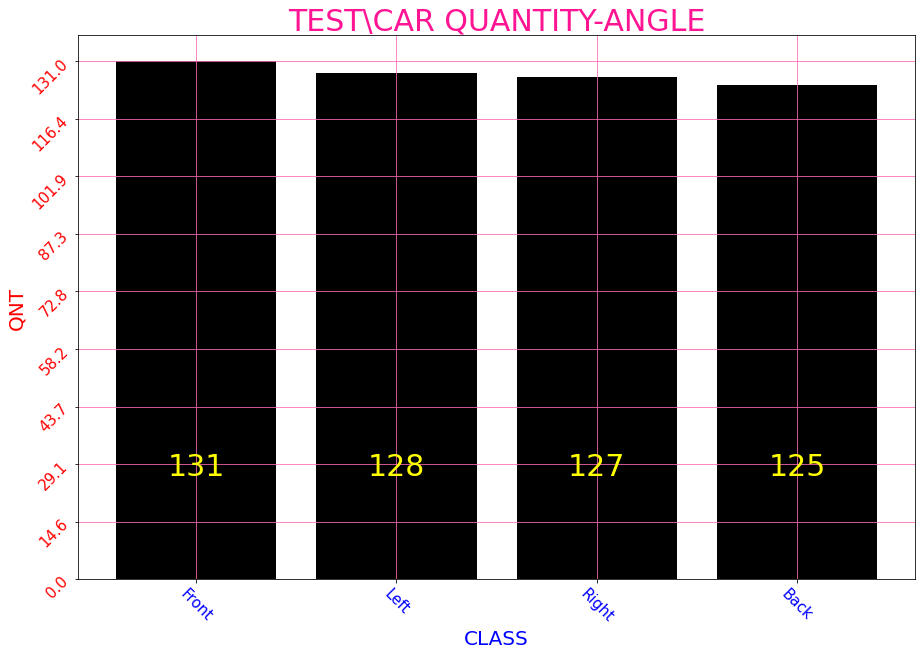

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_car_df_by_angle_count.index,
       height=test_car_df_by_angle_count['ID'],
       color='black')
plt.title('TEST\CAR QUANTITY-ANGLE',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_car_df_by_angle_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_car_df_by_angle_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_car_df_by_angle_count['ID']):
    plt.text(index,
            test_car_df_by_angle_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### test-moto

In [ ]:
# Сгруппируем тестовые мото ракурсу и посчитаем количество записей в каждой группе.
test_moto_df_by_angle_count = test_moto_df.groupby('angle').count()
test_moto_df_by_angle_count.sort_values(by='ID', ascending=False, inplace=True)
test_moto_df_by_angle_count

,ID,maker,class,Inner ID
angle,,,,
Right,134,134,134,134
Back,132,132,132,132
Left,129,129,129,129
Front,127,127,127,127


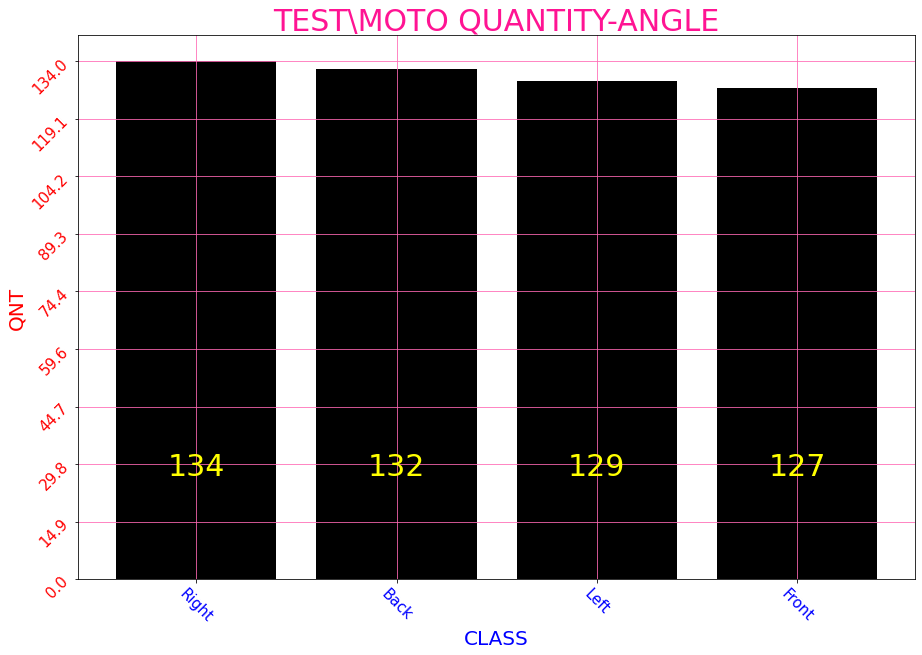

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=test_moto_df_by_angle_count.index,
       height=test_moto_df_by_angle_count['ID'],
       color='black')
plt.title('TEST\MOTO QUANTITY-ANGLE',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(test_moto_df_by_angle_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, test_moto_df_by_angle_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(test_moto_df_by_angle_count['ID']):
    plt.text(index,
            test_moto_df_by_angle_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-car

In [ ]:
# Сгруппируем тестовые мото ракурсу и посчитаем количество записей в каждой группе.
train_car_df_by_angle_count = train_car_df.groupby('angle').count()
train_car_df_by_angle_count.sort_values(by='ID', ascending=False, inplace=True)
train_car_df_by_angle_count

,ID,maker,class,Inner ID
angle,,,,
Front,129,129,129,129
Back,127,127,127,127
Left,126,126,126,126
Right,126,126,126,126


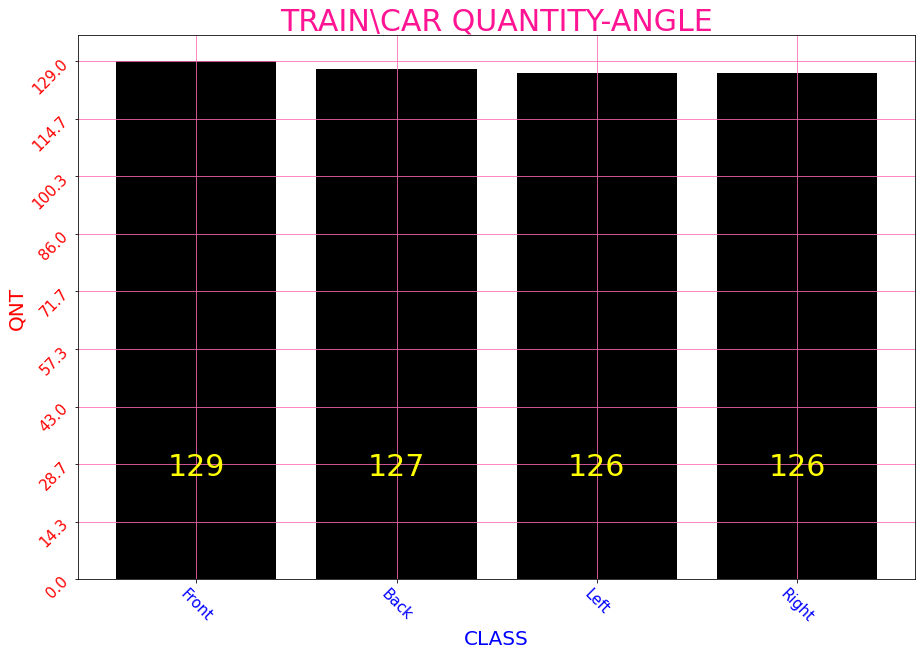

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_car_df_by_angle_count.index,
       height=train_car_df_by_angle_count['ID'],
       color='black')
plt.title('TRAIN\CAR QUANTITY-ANGLE',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_car_df_by_angle_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_car_df_by_angle_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_car_df_by_angle_count['ID']):
    plt.text(index,
            train_car_df_by_angle_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

#### train-moto

In [ ]:
# Сгруппируем тестовые мото ракурсу и посчитаем количество записей в каждой группе.
train_moto_df_by_angle_count = train_moto_df.groupby('angle').count()
train_moto_df_by_angle_count.sort_values(by='ID', ascending=False, inplace=True)
train_moto_df_by_angle_count

,ID,maker,class,Inner ID
angle,,,,
Front,131,131,131,131
Back,130,130,130,130
Right,127,127,127,127
Left,124,124,124,124


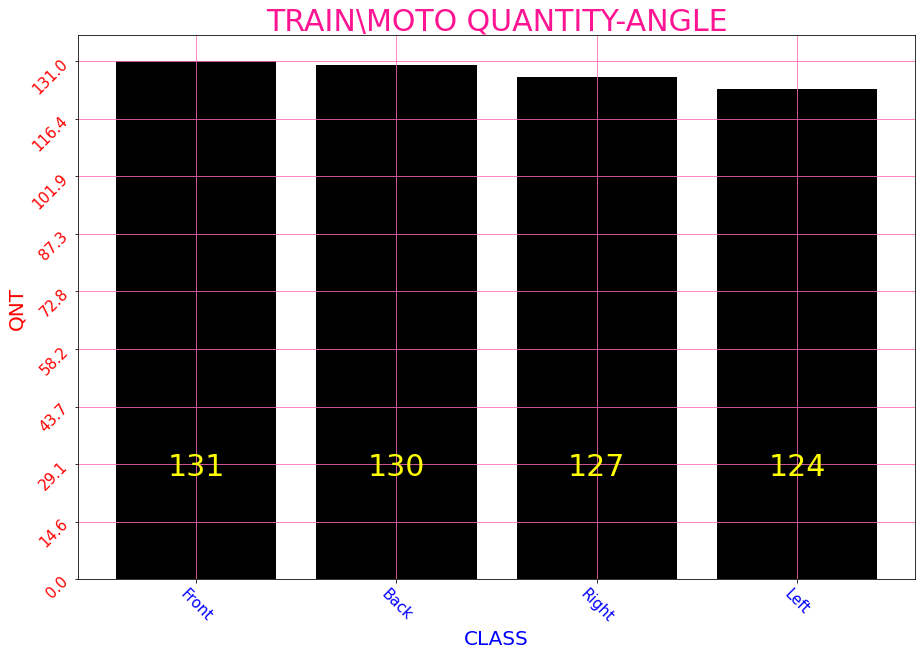

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(x=train_moto_df_by_angle_count.index,
       height=train_moto_df_by_angle_count['ID'],
       color='black')
plt.title('TRAIN\MOTO QUANTITY-ANGLE',
          size=30,
          color='#FF1493')
plt.xlabel('CLASS',
          size=20,
          color='blue')
plt.ylabel('QNT',
          size=20,
          color='red')
plt.xticks(train_moto_df_by_angle_count.index, 
           size=15, 
           color='blue',
           rotation=-45)
plt.yticks(np.linspace(0, train_moto_df_by_angle_count['ID'].max(), 10),
          size=15,
          color='red',
          rotation=45)

for index,value in enumerate(train_moto_df_by_angle_count['ID']):
    plt.text(index,
            train_moto_df_by_angle_count['ID'].max()/5,
            '{:,}'.format(round(value)).replace(',',' '),
            color='#FFFF00',
            rotation=0,
            size=30,
            horizontalalignment='center')
plt.grid(color='#FF69B4')
plt.show()

# 7. Обучение.

## 7.1. Загружаем данные.

In [ ]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import gdown

In [ ]:
url_test_zip = 'https://drive.google.com/uc?export=download&id=1hPkxWdV_23OxVGTcTEz-upXZXdcpMnJw'
output_test_zip = 'test.zip'
gdown.download(url_test_zip, output_test_zip)

Downloading...
From: https://drive.google.com/uc?export=download&id=1hPkxWdV_23OxVGTcTEz-upXZXdcpMnJw
To: /content/test.zip
100%|██████████| 1.12G/1.12G [00:06<00:00, 171MB/s]


'test.zip'

In [ ]:
url_train_zip = 'https://drive.google.com/uc?export=download&id=1hQgE62uwqT2JOXbFAZuusvqHkzocbp-V'
output_train_zip = 'train.zip'
gdown.download(url_train_zip, output_train_zip)

Downloading...
From: https://drive.google.com/uc?export=download&id=1hQgE62uwqT2JOXbFAZuusvqHkzocbp-V
To: /content/train.zip
100%|██████████| 841M/841M [00:05<00:00, 145MB/s]


'train.zip'

In [ ]:
!ls

drive  sample_data  test.zip  train.zip


In [ ]:
!unzip -q train.zip

In [ ]:
!unzip -q test.zip

In [ ]:
!ls train

car  moto


In [ ]:
!ls test

car  moto


## 7.2. Смотрим примеры картинок.

### test-car

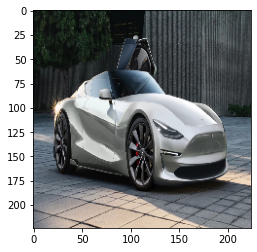

In [ ]:
img_path = 'test/car/bbda0c51-69aa-4776-ae8d-06e4ceb8857a---Tesla-Coupe-Left.jpg'
img = image.load_img(img_path, target_size = (224,224))
plt.imshow(img)
plt.show()

### test-moto

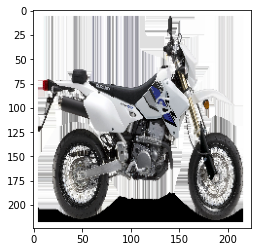

In [ ]:
img_path = 'test/moto/93a44be6-da33-4ea3-8f4b-1309fb0c0091---Suzuki-Motard-Left.jpg'
img = image.load_img(img_path, target_size = (224,224))
plt.imshow(img)
plt.show()

### train-car

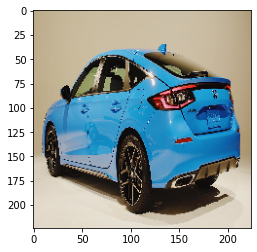

In [ ]:
img_path = 'train/car/c445bd99-94b4-464d-ad8e-e2d0e87391e7---Honda-Hatchback-Back.jpg'
img = image.load_img(img_path, target_size = (224,224))
plt.imshow(img)
plt.show()

### train-moto

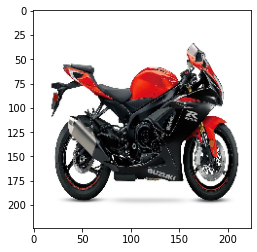

In [ ]:
img_path = 'train/moto/48ef62af-8f3e-4c2c-a155-d0c1b1505e70---Suzuki-Superbike-Right.jpg'
img = image.load_img(img_path, target_size = (224,224))
plt.imshow(img)
plt.show()

## 7.3. Создаем наборы данных.

Набор данных для обучения.

In [ ]:
train_dataset = image_dataset_from_directory('train',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 1020 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

In [ ]:
class_names

['car', 'moto']

In [ ]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 1033 files belonging to 2 classes.


## 7.4. Создаем составную нейронную сеть

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 0s 0us/step


Компилируем составную нейронную сеть

In [ ]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## 7.5. Обучаем сеть

In [ ]:
history = model.fit(train_dataset,
                    epochs=10)

Epoch 1/10


8/8 [==============================] - 96s 8s/step - loss: 0.6532 - accuracy: 0.6804
Epoch 2/10
8/8 [==============================] - 80s 8s/step - loss: 0.3857 - accuracy: 0.8569
Epoch 3/10
8/8 [==============================] - 75s 8s/step - loss: 0.2781 - accuracy: 0.8882
Epoch 4/10
8/8 [==============================] - 78s 7s/step - loss: 0.2526 - accuracy: 0.9137
Epoch 5/10
8/8 [==============================] - 73s 7s/step - loss: 0.2291 - accuracy: 0.9176
Epoch 6/10
8/8 [==============================] - 75s 8s/step - loss: 0.2105 - accuracy: 0.9137
Epoch 7/10
8/8 [==============================] - 81s 8s/step - loss: 0.2071 - accuracy: 0.9255
Epoch 8/10
8/8 [==============================] - 73s 7s/step - loss: 0.1948 - accuracy: 0.9245
Epoch 9/10
8/8 [==============================] - 74s 7s/step - loss: 0.1661 - accuracy: 0.9451
Epoch 10/10
8/8 [==============================] - 78s 8s/step - loss: 0.1704 - accuracy: 0.9304


Проверяем качество обучения на тестовом наборе данных

In [ ]:
scores = model.evaluate(test_dataset, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

9/9 [==============================] - 78s 6s/step - loss: 0.2206 - accuracy: 0.9535
Доля верных ответов на тестовых данных, в процентах: 95.3533


## 7.6. Использование нейронной сети для распознавания изображений

Вспоминаем номера классов:

In [ ]:
class_names

['car', 'moto']

Загружаем изображение из файла:

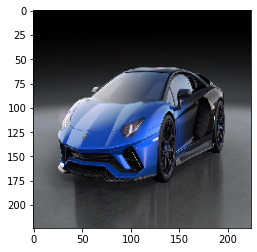

In [ ]:
img_path = 'test/car/e16dddcc-4986-4eaa-9231-4bdbb5f971fc---Lamborghini-Estate-Front.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив:

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание:

In [ ]:
model.predict(x)

1/1 [==============================] - 0s 90ms/step


array([[0.21161729]], dtype=float32)